In [1]:
import numpy as np
import pandas as pd
import psycopg2
from psycopg2.extras import execute_batch
import uuid
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import folium
from folium.plugins import HeatMap

## Constants

In [2]:
RIDER_DETOUR_PROBS = [0.3, 0.25, 0.2, 0.1, 0.1, 0.05]
DRIVER_DETOUR_PROBS = [0.3, 0.25, 0.2, 0.1, 0.1, 0.05]
RIDER_RATIO = 0.5
MIN_TRIP_DISTANCE_METERS = 6000
AVG_TRIP_DISTANCE_METERS = 22300

In [10]:
dataset_file_path_sf = "C:/Users/mariam/Downloads/Datasets/New folder/san francisco/Taxi_Trips.csv"
dataset_file_path_ch = "C:/Users/mariam/Downloads/Datasets/New folder/Taxi Trips Chicago 2024/Taxi_Trips_-_2024_20240408.csv"
dataset_file_path_nyc = "C:/Users/mariam/Downloads/Datasets/archive/nyc_taxi_data_2014(1).csv"

In [11]:
columns_to_keep_sf = [
    'start_time_local',
    'end_time_local',
    'pickup_location_latitude',
    'pickup_location_longitude',
    'dropoff_location_latitude',
    'dropoff_location_longitude',
    "fare_time_milliseconds",
    'trip_distance_meters'
]
columns_to_keep_ch = [
    "Trip Start Timestamp",
    "Trip End Timestamp",
    "Pickup Centroid Latitude",
    "Pickup Centroid Longitude",
    "Dropoff Centroid Latitude",
    "Dropoff Centroid Longitude",
    "Trip Seconds",
    "Trip Miles"
]  
columns_to_keep_nyc = {
    "pickup_datetime":"start_time",
    "dropoff_datetime": "end_time",
    "pickup_latitude" : "pickup_latitude",
    "pickup_longitude": "pickup_longitude",
    "dropoff_latitude": "dropoff_latitude",
    "dropoff_longitude": "dropoff_longitude",
    "passenger_count" : "passenger_count",
    "trip_distance": "trip_distance_meters",
}

rename_columns = [
    "start_time",
    "end_time",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
    "trip_seconds",
    "trip_distance_meters"
]

## Read Dataset

In [25]:
def load_dataset(file_path, columns_to_keep, rename_columns=None, millisecond_to_second=False, miles_to_meters=False):
    """Load and filter a dataset from CSV file"""
    df = pd.read_csv(file_path)
    df = df[columns_to_keep]
    
    # Create a dictionary mapping old column names to new column names if rename_columns is provided
    # Check if rename_columns is already a dictionary
    if not isinstance(rename_columns, dict):
        # Convert the list to a dictionary
        rename_dict = {old: new for old, new in zip(columns_to_keep, rename_columns)}
    else:
        rename_dict = rename_columns
    
    # Now rename the columns with the dictionary
    df = df.rename(columns=rename_dict)
        
    if millisecond_to_second:
        df['trip_seconds'] = df['trip_seconds'] / 1000
    if miles_to_meters:
        df['trip_distance_meters'] = df['trip_distance_meters'] * 1609.344
    return df

    
def plot_distribution(df, column, x_unit, x_factor=1, lower_quantile=0.01, upper_quantile=0.99, bins=30):
    """
    Plots the distribution of a specified column in a DataFrame,
    focusing on the majority of the values by trimming outliers based on quantiles.
    
    Parameters:
        df (DataFrame): The input dataset.
        column (str): The column to plot.
        lower_quantile (float): Lower quantile for trimming (default 1%).
        upper_quantile (float): Upper quantile for trimming (default 99%).
        bins (int): Number of bins in the histogram.
    """
    # Drop NaN values
    data = df[column].dropna()
    
    # Compute quantile range
    lower_bound = data.quantile(lower_quantile)
    upper_bound = data.quantile(upper_quantile)
    
    # Filter data within quantile range
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_data, bins=bins, kde=True, color='skyblue')
    
    plt.title(f'Distribution of {column} (Focused on {lower_quantile*100:.0f}%-{upper_quantile*100:.0f}%)')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x/1e3)}K'))

    # Format x-axis to show values in 'minutes' instead of 'seconds'
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x * x_factor)} {x_unit}'))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
def analyze_trips_per_day(df, date_column="start_time", lower_quantile=0.1, upper_quantile=0.9):
    """
    Analyze the average trips per day in a dataset.
    
    Parameters:
        df (DataFrame): The input taxi dataset
        date_column (str): The column containing timestamp data
    
    Returns:
        dict: Statistics about trips per day
    """
    # Ensure the date column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
        df[date_column] = pd.to_datetime(df[date_column])
    
    # Extract date (without time) for grouping
    df['date'] = df[date_column].dt.date
    
    # Group by date and count trips per day
    # Group by date and count trips per day, then filter to 90th percentile
    trips_per_day = df.groupby('date').size()
    
    lower_bound = trips_per_day.quantile(lower_quantile)
    upper_bound = trips_per_day.quantile(upper_quantile)
    
    filtered_data = trips_per_day[(trips_per_day >= lower_bound) & (trips_per_day <= upper_bound)]
    
    # Calculate statistics
    stats = {
        'average_trips_per_day': trips_per_day.mean(),
        'median_trips_per_day': trips_per_day.median(),
        'min_trips_per_day': trips_per_day.min(),
        'max_trips_per_day': trips_per_day.max(),
        'total_days': len(trips_per_day)
    }
    
    # Plot the distribution of trips per day
    plt.figure(figsize=(12, 6))
    
    # Line plot showing trips over time
    plt.subplot(1, 2, 1)
    filtered_data.plot(kind='line', color='blue')
    plt.title('Trips per Day Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Histogram showing distribution of daily trips
    plt.subplot(1, 2, 2)
    sns.histplot(filtered_data, bins=30, kde=True, color='green')
    plt.title('Distribution of Daily Trip Counts')
    plt.xlabel('Number of Trips per Day')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return stats
    


In [ ]:

def plot_pickup_dropoff_map(df, city_name, sample_size=10000):
    """
    Creates an interactive map showing pickup and dropoff locations with heatmap.
    
    Parameters:
        df: DataFrame containing the taxi trip data
        city_name: Name of the city for the map title
        sample_size: Number of points to sample (for better performance)
    """
    # Sample data if it's too large
    if len(df) > sample_size:
        df_sample = df.sample(sample_size, random_state=42)
    else:
        df_sample = df
    
    # Calculate center of the map
    center_lat = df_sample['pickup_latitude'].mean()
    center_lon = df_sample['pickup_longitude'].mean()
    
    # Create a base map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Add title
    title_html = f'<h3 align="center" style="font-size:16px"><b>{city_name} Taxi Trip Data</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Create feature groups for pickups and dropoffs
    pickup_group = folium.FeatureGroup(name='Pickup Locations')
    dropoff_group = folium.FeatureGroup(name='Dropoff Locations')
    
    # Add pickup points heatmap
    pickup_data = [[row['pickup_latitude'], row['pickup_longitude']] for _, row in df_sample.iterrows()]
    HeatMap(pickup_data, radius=15, gradient={0.2: 'blue', 0.5: 'lime', 0.8: 'red'}).add_to(pickup_group)
    
    # Add dropoff points heatmap
    dropoff_data = [[row['dropoff_latitude'], row['dropoff_longitude']] for _, row in df_sample.iterrows()]
    HeatMap(dropoff_data, radius=15, gradient={0.2: 'green', 0.5: 'purple', 0.8: 'orange'}).add_to(dropoff_group)
    
    # Add the feature groups to the map
    pickup_group.add_to(m)
    dropoff_group.add_to(m)
    
    # Add layer control to toggle between pickup and dropoff views
    folium.LayerControl().add_to(m)
    
    return m


### San Francisco Dataset

C:\Users\mariam\AppData\Local\Temp\ipykernel_22008\3685139103.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


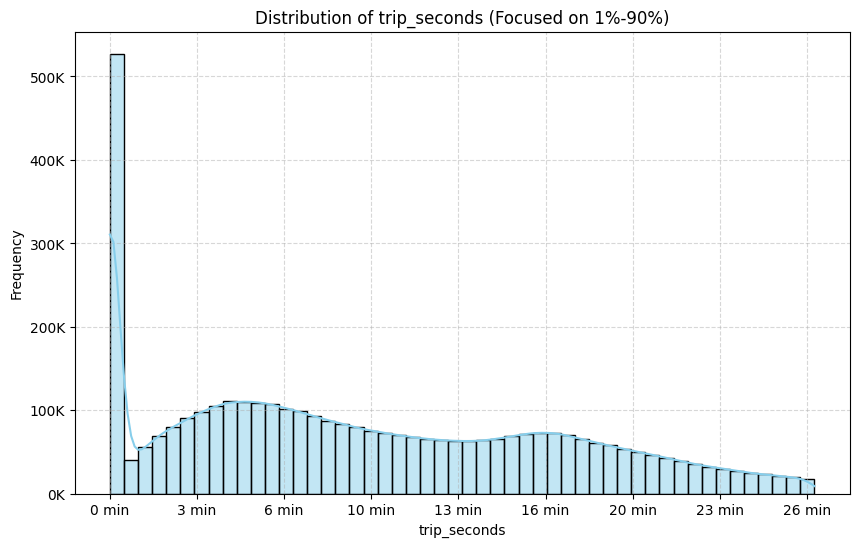

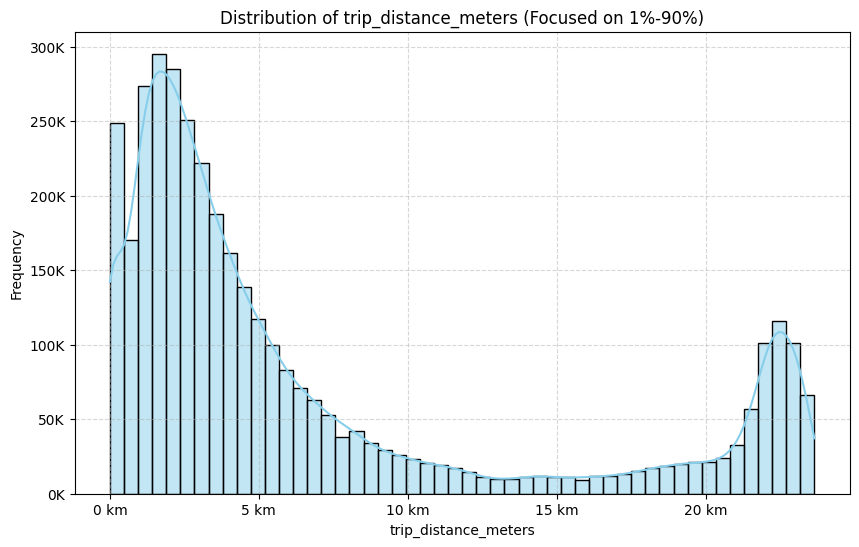

,start_time,end_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,trip_distance_meters
0,2022/12/24 12:12:25 AM,2022/12/24 12:53:45 AM,37.617,-122.386,37.935,-122.518,2081.284,44257.0000
1,2023/01/23 06:37:21 AM,2023/01/23 06:49:34 AM,37.794,-122.396,37.776,-122.394,733.248,2735.8848
2,2023/10/21 08:13:59 PM,2023/10/21 08:19:49 PM,37.614,-122.385,37.602,-122.370,349.867,4506.2000
3,2022/12/24 12:12:41 AM,2022/12/24 12:31:49 AM,37.615,-122.385,37.786,-122.410,983.000,22445.5490
4,2023/01/23 06:37:21 AM,2023/01/23 06:49:34 AM,37.794,-122.396,37.776,-122.394,733.248,2735.8848


In [ ]:
dataset_sf = load_dataset(dataset_file_path_sf, columns_to_keep_sf,rename_columns, millisecond_to_second=True)
print(dataset_sf.shape[0], "rows")
plot_distribution(dataset_sf, "trip_seconds",x_factor=1/60,x_unit="min",upper_quantile=0.9, bins=50)
plot_distribution(dataset_sf, "trip_distance_meters",x_factor=1/1000, x_unit="km", upper_quantile=0.9, bins=50)

# print(dataset_sf.describe())
dataset_sf.head()


In [ ]:
analyze_trips_per_day(dataset_sf, date_column="start_time", lower_quantile=0.1, upper_quantile=0.8)

In [ ]:
sf_map = plot_pickup_dropoff_map(dataset_sf, "San Francisco")
sf_map

### Chicago Dataset

865247 rows


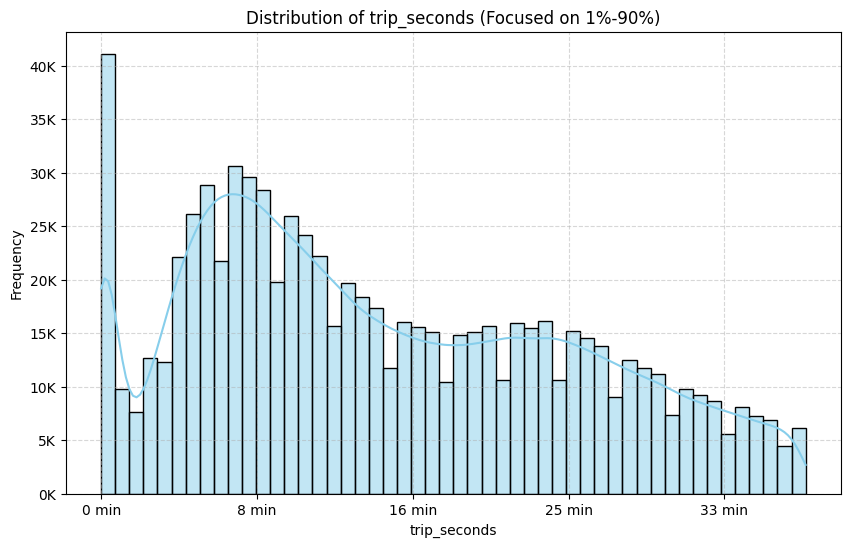

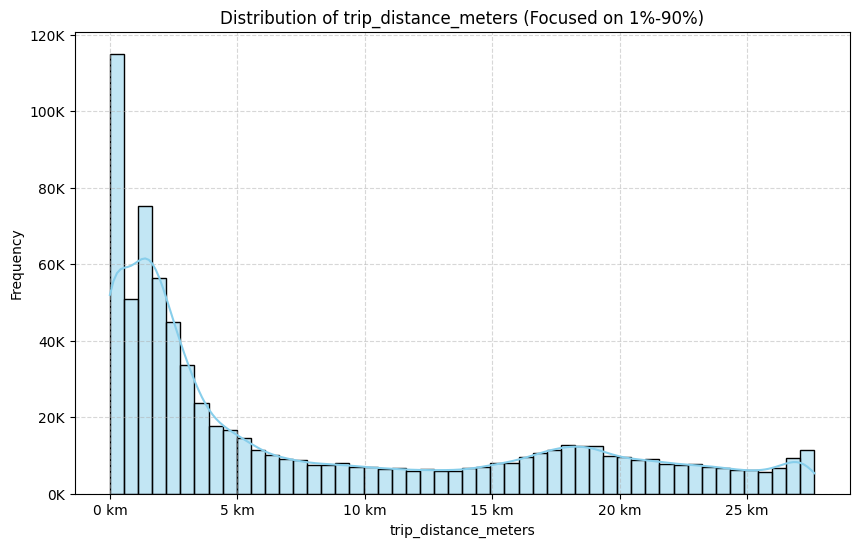

,start_time,end_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_seconds,trip_distance_meters
0,03/01/2024 12:00:00 AM,03/01/2024 12:00:00 AM,41.899602,-87.633308,41.899602,-87.633308,15.0,144.84096
1,03/01/2024 12:00:00 AM,03/01/2024 12:15:00 AM,41.901207,-87.676356,41.899602,-87.633308,900.0,4828.03200
2,03/01/2024 12:00:00 AM,03/01/2024 12:00:00 AM,41.792592,-87.769615,NaN,NaN,711.0,9398.56896
3,03/01/2024 12:00:00 AM,03/01/2024 12:30:00 AM,41.980264,-87.913625,41.965812,-87.655879,1770.0,21500.83584
4,03/01/2024 12:00:00 AM,03/01/2024 12:15:00 AM,41.899602,-87.633308,41.965812,-87.655879,849.0,9865.27872


In [ ]:
dataset_ch = load_dataset(dataset_file_path_ch, columns_to_keep_ch,rename_columns, miles_to_meters=True)
print(dataset_ch.shape[0], "rows")
plot_distribution(dataset_ch, "trip_seconds",x_factor=1/60,x_unit="min",upper_quantile=0.9, bins=50)
plot_distribution(dataset_ch, "trip_distance_meters",x_factor=1/1000, x_unit="km", upper_quantile=0.9, bins=50)
dataset_ch.head()

In [ ]:
analyze_trips_per_day(dataset_ch, date_column="start_time", lower_quantile=0.1, upper_quantile=0.8)

In [ ]:
ch_map = plot_pickup_dropoff_map(dataset_ch, "Chicago")
ch_map

### NYC Dataset

C:\Users\mariam\AppData\Local\Temp\ipykernel_23712\2196181966.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


14999999 rows


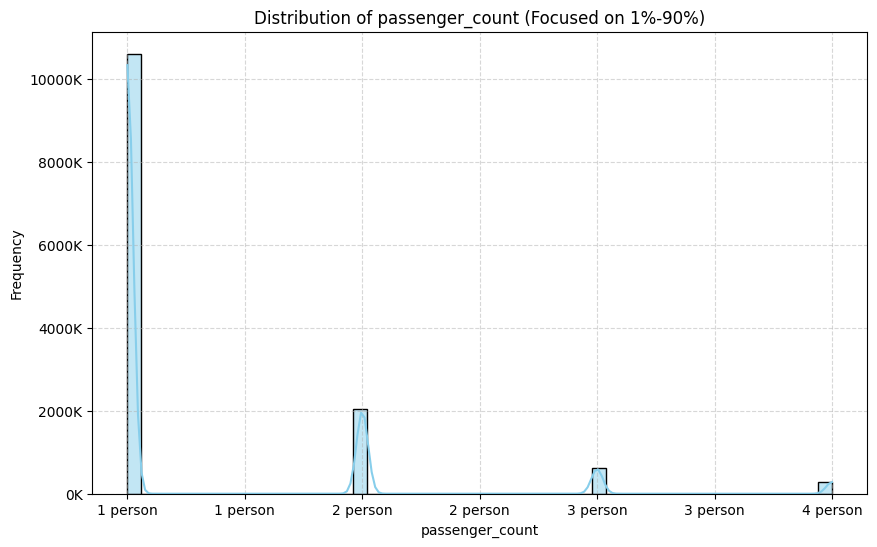

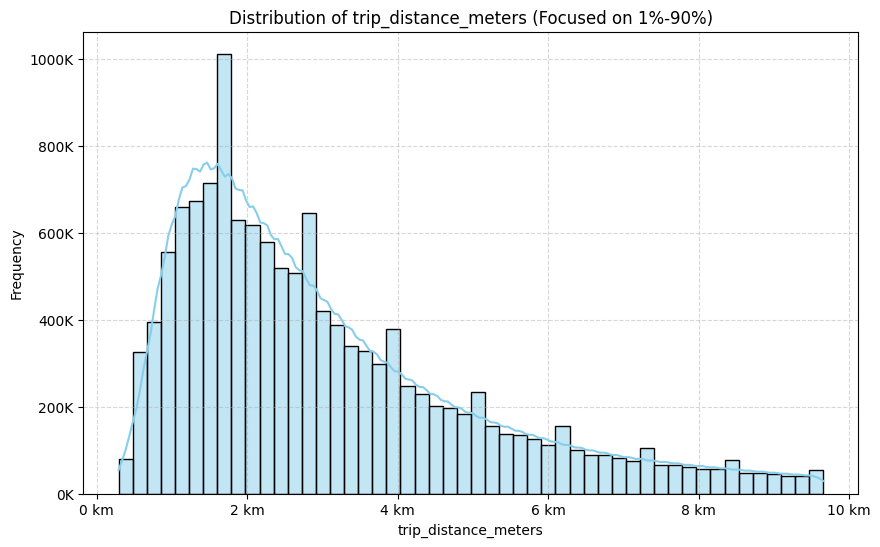

,start_time,end_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,trip_distance_meters
0,2014-01-09 20:45:25,2014-01-09 20:52:31,40.736828,-73.994770,40.731790,-73.982227,1,1126.5408
1,2014-01-09 20:46:12,2014-01-09 20:55:12,40.773382,-73.982392,40.763995,-73.960449,1,2253.0816
2,2014-01-09 20:44:47,2014-01-09 20:59:46,40.739406,-73.988570,40.765217,-73.986626,2,3701.4912
3,2014-01-09 20:44:57,2014-01-09 20:51:40,40.770464,-73.960213,40.777050,-73.979863,1,2735.8848
4,2014-01-09 20:47:09,2014-01-09 20:53:32,40.717248,-73.995371,40.720524,-73.984367,1,1448.4096


In [12]:
dataset_nyc = load_dataset(dataset_file_path_nyc, list(columns_to_keep_nyc.keys()),columns_to_keep_nyc,miles_to_meters=True)
print(dataset_nyc.shape[0], "rows")
plot_distribution(dataset_nyc, "passenger_count",x_unit="person",upper_quantile=0.9, bins=50)
plot_distribution(dataset_nyc, "trip_distance_meters",x_factor=1/1000, x_unit="km", upper_quantile=0.9, bins=50)
dataset_nyc.head()


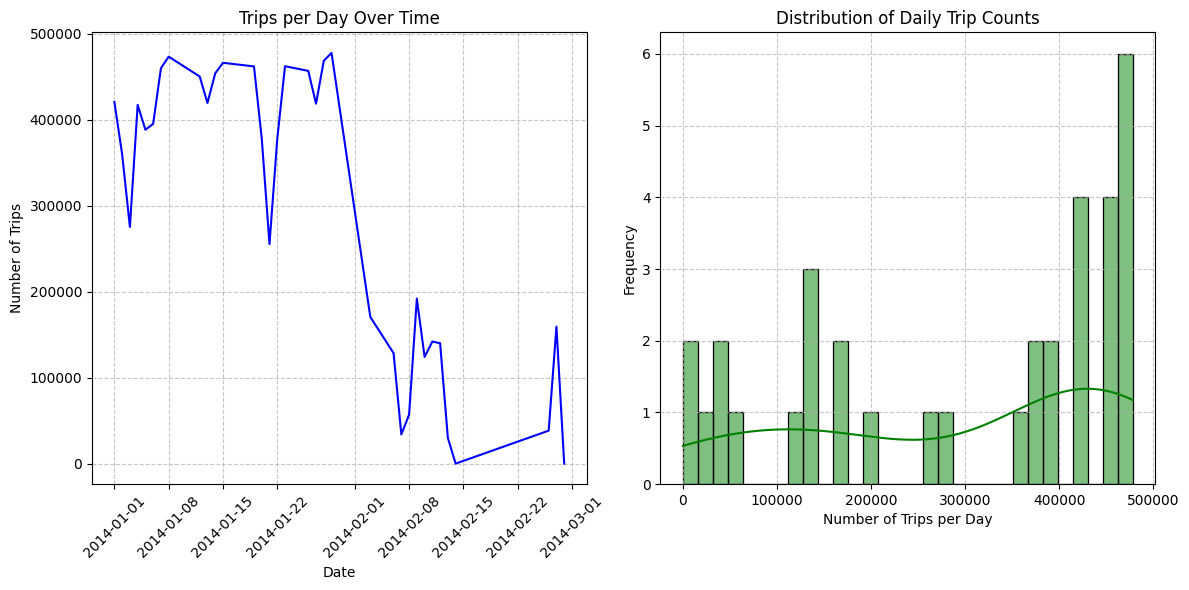

{'average_trips_per_day': 306122.4285714286,
 'median_trips_per_day': 395445.0,
 'min_trips_per_day': 4,
 'max_trips_per_day': 530551,
 'total_days': 49}

In [28]:
analyze_trips_per_day(dataset_nyc, date_column="start_time", lower_quantile=0.1, upper_quantile=0.8)

In [ ]:
nyc_map = plot_pickup_dropoff_map(dataset_nyc, "New York City")
nyc_map

## Data filtration

TODO
- filtration 
- check distribution 
- 
- eltime / sizes / number of samples /

## Data Generation

In [ ]:
def meters_to_minutes(meters):
    """Convert trip distance in meters to estimated duration in minutes"""
    # Assuming average speed of 30 km/h = 500 meters per minute
    return max(1, int(meters / 500))

def generate_detour_duration_minutes(weights):
    values = [0, 10, 15, 20, 25, 30]
    return random.choices(values, weights=weights)[0]

def generate_capacity():
    values = [1, 2, 3]
    weights = [0.1, 0.4, 0.35, 0.15]
    return random.choices(values, weights=weights)[0]

def generate_max_walking_duration_minutes():
    values = [5, 10, 15, 20, 25]
    weights = [0.3, 0.35, 0.2, 0.1, 0.05]
    return random.choices(values, weights=weights)[0]

def generate_number_of_riders_per_request():
    values = [1, 2, 3]
    weights = [0.6, 0.3, 0.1]
    return random.choices(values, weights=weights)[0]

def generate_same_gender_preference(gender):
    weights = {
        'female': [0.65, 0.35],
        'male': [0.15, 0.85]   
    }
    gender_weights = weights.get(gender, [0.3, 0.7])  
    
    return random.choices([True, False], weights=gender_weights)[0]

def generate_gender(driver=False):
    if driver:
        return random.choices(['male', 'female'], weights=[0.7, 0.3])[0]
    else:
        return random.choices(['male', 'female'], weights=[0.45, 0.55])[0]

def generate_max_estimated_arrival_time(distance, detour_duration):
    """Generate a random maximum estimated arrival time"""
    return meters_to_minutes(distance) + detour_duration

In [ ]:
def create_rider_requests(data_chunk, start_idx, dataset_id=None, config=None):
    """Create rider requests from a data chunk"""
    requests = []
    
    for i, row in data_chunk.iterrows():
        # Generate a unique ID with optional dataset prefix
        prefix = f"ds{dataset_id}-" if dataset_id is not None else ""
        request_id = f"{prefix}req-{start_idx + i:06d}"
        user_id = f"{prefix}user-{random.randint(1000, 9999)}"
        
        # Parse timestamps
        earliest_departure = pd.to_datetime(row['start_time_local'])
        latest_arrival = pd.to_datetime(row['end_time_local'])
        
        # First generate gender
        gender = generate_gender(driver=False)
        
        # Then generate preferences that correlate with gender
        prefs = generate_preferences(gender)
        
        # Generate other parameters with appropriate configurations
        num_riders = generate_capacity(is_driver=False)
        max_walking = generate_max_walking_duration_minutes()
        
        requests.append((
            request_id,
            user_id,
            float(row['pickup_location_latitude']),
            float(row['pickup_location_longitude']),
            None,  # source_address
            float(row['dropoff_location_latitude']),
            float(row['dropoff_location_longitude']),
            None,  # destination_address
            earliest_departure,
            latest_arrival,
            max_walking,
            num_riders,
            prefs['same_gender'],
            prefs['allows_smoking'],
            prefs['allows_pets'],
            gender,
            dataset_id  # Add dataset_id as the last column
        ))
    
    return requests

In [ ]:
def create_driver_offers(data_chunk, start_idx, dataset_id=None):
    offers = []
    
    for i, row in data_chunk.iterrows():
        # Generate a unique ID
        prefix = f"ds{dataset_id}-" if dataset_id is not None else ""
        offer_id = f"{prefix}drv-{start_idx + i:06d}"
        user_id = f"{prefix}user-{random.randint(10000, 99999)}"
        
        # Parse timestamps
        departure_time = pd.to_datetime(row['start_time_local'])
        estimated_arrival = pd.to_datetime(row['end_time_local'])
        
        # Calculate maximum estimated arrival (add buffer)
        buffer_minutes = random.randint(5, 30)
        max_arrival = estimated_arrival + timedelta(minutes=buffer_minutes)
        
        # Convert distance to detour minutes
        detour_minutes = meters_to_minutes(row['trip_distance_meters'])
        
        # Random capacity (2-6)
        capacity = random.randint(2, 6)
        
        # Generate random preferences
        prefs = random_preferences()
        gender = random_gender()
        
        offers.append((
            offer_id,
            user_id,
            float(row['pickup_location_latitude']),
            float(row['pickup_location_longitude']),
            None,  # source_address
            float(row['dropoff_location_latitude']),
            float(row['dropoff_location_longitude']),
            None,  # destination_address
            departure_time,
            max_arrival,
            estimated_arrival,
            detour_minutes,
            capacity,
            0,  # current_number_of_requests
            prefs['same_gender'],
            prefs['allows_smoking'],
            prefs['allows_pets'],
            gender,
            dataset_id  # Add dataset_id as the last column
        ))
    
    return offers

In [ ]:
def create_multiple_datasets(file_path, dataset_count=3, rows_per_dataset=None):
    """Create multiple distinct datasets in the database"""
    df = load_dataset(file_path)
    
    # If rows_per_dataset is not specified, use the full dataset for each
    if rows_per_dataset is None or rows_per_dataset > len(df):
        rows_per_dataset = len(df)
    
    for dataset_id in range(1, dataset_count + 1):
        print(f"\nCreating dataset #{dataset_id}")
        
        # Sample subset of data
        if len(df) > rows_per_dataset:
            sample_df = df.sample(n=rows_per_dataset)
        else:
            sample_df = df
            
        # Apply time shift for dataset variety (optional)
        # Each dataset shifts forward by a week from the last
        day_shift = timedelta(days=(dataset_id-1) * 7)
        sample_df = sample_df.copy()
        sample_df['start_time_local'] = pd.to_datetime(sample_df['start_time_local']) + day_shift
        sample_df['end_time_local'] = pd.to_datetime(sample_df['end_time_local']) + day_shift
        
        # Insert this dataset
        insert_into_database(sample_df, dataset_id=dataset_id)

In [ ]:

# Create a single dataset
# df = load_dataset("C:/Users/mariam/Downloads/Datasets/New folder/san francisco/Taxi_Trips.csv")
# insert_into_database(df)

# Or create multiple datasets
create_multiple_datasets(
    "C:/Users/mariam/Downloads/Datasets/New folder/san francisco/Taxi_Trips.csv",
    dataset_count=3,
    rows_per_dataset=5000  # Number of rows per dataset
)

### Performance Dataset Generation

#### Generate Different Sizes of Survey Distribution 

### Matching Percentage Dataset Generation

#### Maximum Number of Requests per Driver Offer 

#### Number of Drivers to Riders

#### Driver Detour

#### Rider Walking Time

#### Rider Time Tolerance

## Write into Database

In [ ]:
def connect_to_database():
    """Connect to the database using environment variables"""
    # Load environment variables
    load_dotenv()
    
    # Database connection parameters
    db_params = {
        'host': os.getenv('DB_HOST', 'localhost'),
        'database': os.getenv('DB_NAME', 'matching_engine'),
        'user': os.getenv('DB_USER', 'postgres'),
        'password': os.getenv('DB_PASSWORD'),
        'port': os.getenv('DB_PORT', '5432')
    }
    
    # Check if password is available
    if not db_params['password']:
        raise ValueError("DB_PASSWORD environment variable is not set")
    
    # Connect to database and return connection and cursor
    conn = psycopg2.connect(**db_params)
    return conn

In [ ]:
def insert_into_database(df, chunk_size=1000, dataset_id=None, rider_ratio=0.6):
    """Process and insert data into database tables"""
    conn = connect_to_database()
    cursor = conn.cursor()
    
    try:
        # Split data: rider_ratio% for rider requests, the rest for driver offers
        split_point = int(len(df) * rider_ratio)
        rider_data = df.iloc[:split_point].reset_index(drop=True)
        driver_data = df.iloc[split_point:].reset_index(drop=True)
        
        print(f"Creating {len(rider_data)} rider requests and {len(driver_data)} driver offers")
        
        # Insert rider requests
        for chunk_start in range(0, len(rider_data), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(rider_data))
            chunk = rider_data.iloc[chunk_start:chunk_end]
            
            requests = create_rider_requests(chunk, chunk_start, dataset_id)
            
            # SQL for inserting rider requests
            insert_rider_sql = """
            INSERT INTO rider_requests (
                id, user_id, 
                source_latitude, source_longitude, source_address,
                destination_latitude, destination_longitude, destination_address,
                earliest_departure_time, latest_arrival_time,
                max_walking_duration_minutes, number_of_riders,
                same_gender, allows_smoking, allows_pets, user_gender, dataset_id
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """
            
            execute_batch(cursor, insert_rider_sql, requests)
            conn.commit()
            print(f"Inserted {len(requests)} rider requests")
        
        # Insert driver offers
        for chunk_start in range(0, len(driver_data), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(driver_data))
            chunk = driver_data.iloc[chunk_start:chunk_end]
            
            offers = create_driver_offers(chunk, chunk_start, dataset_id)
            
            # SQL for inserting driver offers
            # SQL for inserting driver offers
            insert_driver_sql = """
            INSERT INTO driver_offers (
                id, user_id,
                source_latitude, source_longitude, source_address,
                destination_latitude, destination_longitude, destination_address,
                departure_time, max_estimated_arrival_time, estimated_arrival_time,
                detour_duration_minutes, capacity, current_number_of_requests,
                same_gender, allows_smoking, allows_pets, user_gender, dataset_id
            ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """
            
            execute_batch(cursor, insert_driver_sql, offers)
            conn.commit()
            print(f"Inserted {len(offers)} driver offers")
        
        print("Data import completed successfully")
        
    except Exception as e:
        conn.rollback()
        print(f"Error: {e}")
        
    finally:
        cursor.close()
        conn.close()